## Complex Network Analysis: Premier League - Basic Functions

This notebook implements basic functions to load Premier League data, create a complex network for a specific season, and visualize this network.

In [968]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from collections import defaultdict

# Ignore some common warnings for a cleaner display
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning) # For newer pandas and networkx versions

### 1. Data Loading

Function to load the dataset.

In [969]:
def load_data(file_path):
    """
    Loads the dataset from a CSV file.
    
    Args:
        file_path (str): The path to the CSV file.
        
    Returns:
        pandas.DataFrame: The loaded DataFrame, or None if the file is not found.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        print(f"Dataset shape: {df.shape}")
        # Convert MatchDate to datetime if not already
        if 'MatchDate' in df.columns:
             df['MatchDate'] = pd.to_datetime(df['MatchDate'], errors='coerce')
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

### 2. Seasonal Network Creation

Function to create an `nx.MultiDiGraph` network for a given season. The edges represent the defined metrics (using original Italian keys):
- **"Gol"**: Total goal difference of team A against team B.
- **"Tiri efficaci"**: Shooting accuracy ((ShotsOnTarget / Shots) * 100) of team A against team B.
- **"Aggressività"**: Aggressiveness score (Fouls + YellowCards + 3*RedCards) of team A against team B.
- **"Controllo"**: Control score (Corners + Shots) of team A against team B.

In [970]:
def create_epl_network(df, season=None, start_year=None, end_year=None):
    """
    Creates a MultiDiGraph network.
    
    Args:
        df (pandas.DataFrame): The complete match DataFrame.
        season (str, optional): A specific season to analyze (e.g., '2016/17').
                                Takes precedence over start_year/end_year if both are provided.
                                Defaults to None.
        start_year (int, optional): The starting year of the season range (e.g., 2014 for '2014/15').
                                    Defaults to None.
        end_year (int, optional): The ending year of the season range (e.g., 2017 for '2016/17').
                                  Defaults to None.

    Returns:
        networkx.MultiDiGraph: The graph, or None if the data to process is empty.
    """
    
    df_to_process = df.copy()
    current_scope_name = "the entire dataset"

    # Determine the scope of data to process based on parameters
    if season:
        # If a specific season string is provided, prioritize it
        df_to_process = df[df['Season'] == season].copy()
        current_scope_name = f"season {season}"
    elif start_year is not None and end_year is not None:
        # If start and end years are provided, generate seasons range
        if not (isinstance(start_year, int) and isinstance(end_year, int)):
            print("Error: start_year and end_year must be integers.")
            return None
        if start_year > end_year:
            print("Error: start_year cannot be greater than end_year.")
            return None

        # Generate season strings like 'YYYY/YY'
        seasons_in_range = []
        for year in range(start_year, end_year):
            next_year_suffix = str(year + 1)[-2:] # e.g., 2017 -> '17'
            seasons_in_range.append(f"{year}/{next_year_suffix}")
        
        df_to_process = df[df['Season'].isin(seasons_in_range)].copy()
        current_scope_name = f"seasons from {start_year}/{str(start_year+1)[-2:]} to {end_year - 1}/{str(end_year)[-2:]}"
    # Else, if neither season nor year range is provided, df_to_process remains the full df

    if df_to_process.empty:
        print(f"No data found for {current_scope_name}.")
        return None

    # Ensure numeric columns are correct and fill NaNs
    cols_to_fill = ['FullTimeHomeGoals', 'FullTimeAwayGoals', 'HomeShots', 'AwayShots',
                    'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners',
                    'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards',
                    'HomeRedCards', 'AwayRedCards']
    for col in cols_to_fill:
        if col in df_to_process.columns:
            df_to_process[col] = pd.to_numeric(df_to_process[col], errors='coerce').fillna(0)
        else:
            # If a critical column is missing, it's problematic
            print(f"Warning: Critical column '{col}' not found in the dataset for {current_scope_name}. Cannot proceed.")
            return None


    # Initialize a dictionary to store aggregated stats for each ORDERED pair (team1, team2)
    # Each entry will store the sum of team1's actions when playing against team2
    stats_cache = defaultdict(lambda: {
        'goals_scored': 0,
        'sot': 0,
        'total_shots': 0,
        'fouls': 0,
        'yc': 0,
        'rc': 0,
        'corners': 0
    })

    # Iterate through each match ONCE in the determined scope to populate the stats_cache
    for _, match in df_to_process.iterrows():
        ht = match['HomeTeam']
        at = match['AwayTeam']

        # Accumulate stats for HomeTeam's performance against AwayTeam in this match
        stats_cache[(ht, at)]['goals_scored'] += match['FullTimeHomeGoals']
        stats_cache[(ht, at)]['sot'] += match['HomeShotsOnTarget']
        stats_cache[(ht, at)]['total_shots'] += match['HomeShots']
        stats_cache[(ht, at)]['fouls'] += match['HomeFouls']
        stats_cache[(ht, at)]['yc'] += match['HomeYellowCards']
        stats_cache[(ht, at)]['rc'] += match['HomeRedCards']
        stats_cache[(ht, at)]['corners'] += match['HomeCorners']

        # Accumulate stats for AwayTeam's performance against HomeTeam in this match
        stats_cache[(at, ht)]['goals_scored'] += match['FullTimeAwayGoals']
        stats_cache[(at, ht)]['sot'] += match['AwayShotsOnTarget']
        stats_cache[(at, ht)]['total_shots'] += match['AwayShots']
        stats_cache[(at, ht)]['fouls'] += match['AwayFouls']
        stats_cache[(at, ht)]['yc'] += match['AwayYellowCards']
        stats_cache[(at, ht)]['rc'] += match['AwayRedCards']
        stats_cache[(at, ht)]['corners'] += match['AwayCorners']

    # Get all unique teams that participated in the selected scope to create nodes
    all_teams_in_scope = pd.concat([df_to_process['HomeTeam'], df_to_process['AwayTeam']]).unique()
    G = nx.MultiDiGraph()
    G.add_nodes_from(all_teams_in_scope)

    # Build the graph using the aggregated stats from stats_cache
    for (team_a, team_b), agg_stats in stats_cache.items():
        # team_a is the source, team_b is the target for these stats

        # 1. "goals" Edge: Weight = total goals scored by team_a against team_b
        weight_goals = float(agg_stats['goals_scored'])
        G.add_edge(team_a, team_b, key="goals", weight=weight_goals)

        # 2. "shot_accuracy" Edge: Weight = accuracy of team_a against team_b
        weight_shot_accuracy = (agg_stats['sot'] / agg_stats['total_shots']) * 100 if agg_stats['total_shots'] > 0 else 0.0
        G.add_edge(team_a, team_b, key="shot_accuracy", weight=float(weight_shot_accuracy))

        # 3. "aggressiveness" Edge: Weight = aggressiveness score of team_a against team_b
        weight_aggressiveness = float(agg_stats['fouls'] + agg_stats['yc'] + 3 * agg_stats['rc'])
        G.add_edge(team_a, team_b, key="aggressiveness", weight=weight_aggressiveness)

        # 4. "control" Edge: Weight = control score of team_a against team_b
        #    (Control = Corners + Total Shots by team_a against team_b)
        weight_control = float(agg_stats['corners'] + agg_stats['total_shots'])
        G.add_edge(team_a, team_b, key="control", weight=weight_control)
        
    print(f"Network created for {current_scope_name} with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

## Normalize network

In [971]:
def normalize_edge_weights(graph: nx.MultiDiGraph, metrics_to_normalize: list = None, target_range: tuple = (0, 1)) -> nx.MultiDiGraph:
    if graph is None or graph.number_of_edges() == 0:
        print("Warning: Input graph is None or has no edges. Returning None.")
        return None

    normalized_graph = graph.copy()
    min_target, max_target = target_range

    if min_target >= max_target:
        raise ValueError("target_range 'min_val' must be less than 'max_val'.")

    # Determine which metrics to normalize
    if metrics_to_normalize is None:
        all_edge_keys = set(multi_edge_key for u, v, multi_edge_key, data in graph.edges(keys=True, data=True) if 'weight' in data)
        metrics_to_normalize = list(all_edge_keys)
        if not metrics_to_normalize:
            print("No 'key' attributes found on edges for normalization. Returning original graph copy.")
            return normalized_graph
        print(f"No specific metrics provided. Normalizing weights for all found metrics: {', '.join(metrics_to_normalize)}")
    else:
        print(f"Normalizing weights for specified metrics: {', '.join(metrics_to_normalize)}")

    try: # Add a try-except block to catch specific errors during normalization
        for metric_key in metrics_to_normalize:
            # Collect all weights for the current metric
            weights = []
            for u, v, multi_edge_key, data in graph.edges(keys=True, data=True):
                if multi_edge_key == metric_key and 'weight' in data:
                    try:
                        # Ensure weight is numeric before adding to list
                        weights.append(float(data['weight']))
                    except ValueError:
                        print(f"    Warning: Non-numeric 'weight' found for edge {u}->{v} (key='{multi_edge_key}'): {data['weight']}. Skipping this weight.")

            if not weights:
                print(f"    No numeric weights found for metric '{metric_key}'. Skipping normalization for this metric.")
                continue

            min_weight = min(weights)
            max_weight = max(weights)

            if max_weight == min_weight:
                print(f"    All weights for '{metric_key}' are the same ({min_weight}). Setting all to {max_target}.")
                for u, v, multi_edge_key, data in normalized_graph.edges(keys=True, data=True):
                    if multi_edge_key == metric_key and 'weight' in data:
                        normalized_graph[u][v][multi_edge_key]['weight'] = max_target
            else:
                for u, v, multi_edge_key, data in normalized_graph.edges(keys=True, data=True):
                    if multi_edge_key == metric_key and 'weight' in data:
                        try:
                            original_weight = float(data['weight'])
                            normalized_weight = (original_weight - min_weight) / (max_weight - min_weight) \
                                                * (max_target - min_target) + min_target
                            normalized_graph[u][v][multi_edge_key]['weight'] = normalized_weight
                        except ValueError:
                            print(f"      Warning: Could not convert weight to float for normalization for edge {u}->{v} (key='{multi_edge_key}').")
                            # Optionally, you might want to set it to a default or skip updating this specific weight
                            continue

        print(f"Edge weights normalized to range {target_range} for specified metrics.")
        return normalized_graph

    except Exception as e:
        print(f"An unexpected error occurred during normalization: {e}")
        # This will now print the specific error, helping us debug
        return None # Return None to indicate failure and trigger abort in main function

### 3. Network Visualization

Basic function to visualize the network. For complex `MultiDiGraph` graphs, visualizing all information simultaneously can be confusing. This function optionally allows visualizing edges related to a single metric.

In [972]:
def visualize_network(G, season_name, metric_to_display=None, file_name=None):
    """
    Visualizes the seasonal network.

    Args:
        G (networkx.MultiDiGraph): The graph to visualize.
        season_name (str): The name of the season (for the plot title).
        metric_to_display (str, optional): The specific metric to display (e.g., "goals").
                                           If None, tries to draw all edges (can be cluttered).
        file_name (str, optional): If provided, saves the image to the specified path.
    """
    if G is None:
        print("Graph is None, cannot visualize.")
        return

    plt.figure(figsize=(14, 10))
    pos = nx.circular_layout(G) # Circular layout, good for leagues
    
    title = f"Premier League Network - Season {season_name}"
    graph_to_draw = G
    edge_labels_to_draw = None

    if metric_to_display:
        # Create a simple graph (DiGraph) with only edges of the specified metric
        G_metric = nx.DiGraph()
        G_metric.add_nodes_from(G.nodes())
        
        # Iterate with keys=True to get the actual edge key
        for u, v, edge_key, data in G.edges(keys=True, data=True):
            if edge_key == metric_to_display: # Check against edge_key directly
                G_metric.add_edge(u, v, weight=data['weight'])
        
        if not G_metric.edges():
            print(f"No edges found for metric '{metric_to_display}'. Displaying base node layout.")
            # Draw only nodes if no edges for the metric
            nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue', alpha=0.9)
            nx.draw_networkx_labels(G, pos, font_size=9)
        else:
            graph_to_draw = G_metric
            title += f" - Metric: {metric_to_display}"
            # Prepare weight labels for edges of the selected metric
            edge_labels_to_draw = {(u, v): f"{d['weight']:.2f}" for u, v, d in G_metric.edges(data=True)}
            # Draw nodes, edges, and labels for the specific metric graph
            nx.draw_networkx_nodes(graph_to_draw, pos, node_size=2000, node_color='skyblue', alpha=0.9)
            nx.draw_networkx_labels(graph_to_draw, pos, font_size=9)
            nx.draw_networkx_edges(graph_to_draw, pos, arrowstyle='->', arrowsize=15, width=1.5, edge_color='teal')
            if edge_labels_to_draw:
                nx.draw_networkx_edge_labels(graph_to_draw, pos, edge_labels=edge_labels_to_draw, font_size=7)

    else: # No specific metric, draw the full MultiDiGraph
        nx.draw_networkx_nodes(graph_to_draw, pos, node_size=2000, node_color='skyblue', alpha=0.9)
        nx.draw_networkx_labels(graph_to_draw, pos, font_size=9)
        # Basic drawing for MultiDiGraph (can be cluttered)
        # Drawing all edges with arrows. For better distinction, you might color by 'key'
        nx.draw_networkx_edges(graph_to_draw, pos, arrowstyle='->', arrowsize=15, 
                               edge_color='gray', alpha=0.5, connectionstyle='arc3,rad=0.1')
        print("Displaying all edges for MultiDiGraph. For clarity, consider specifying 'metric_to_display'.")
    
    plt.title(title, fontsize=15)
    plt.axis('off')
    
    if file_name:
        try:
            plt.savefig(file_name, format='PNG', dpi=300)
            print(f"Plot saved as {file_name}")
        except Exception as e:
            print(f"Error saving plot: {e}")
    plt.show()

In [973]:
def filter_network_by_weight(graph: nx.MultiDiGraph, metric: str, threshold: float, keep_above: bool = True) -> nx.MultiDiGraph:
    """
    Filters edges in a MultiDiGraph based on their 'weight' for a specific metric.
    
    Args:
        graph (nx.MultiDiGraph): The graph to filter.
        metric (str): The edge 'key' (e.g., "goals") to apply the filter on.
        threshold (float): The threshold value for filtering.
        keep_above (bool): If True, keeps edges with weight >= threshold. If False, keeps edges with weight <= threshold.

    Returns:
        nx.MultiDiGraph: A new filtered graph.
    """
    if graph is None:
        print("Cannot filter a None graph.")
        return None

    filtered_graph = nx.MultiDiGraph()
    filtered_graph.add_nodes_from(graph.nodes()) # Keep all nodes, even if isolated

    edges_removed_count = 0
    edges_kept_count = 0

    for u, v, key, data in graph.edges(keys=True, data=True):
        if key == metric and 'weight' in data:
            weight = data['weight']
            if (keep_above and weight >= threshold) or (not keep_above and weight <= threshold):
                filtered_graph.add_edge(u, v, key=key, **data)
                edges_kept_count += 1
            else:
                edges_removed_count += 1
        else:
            # Keep edges of other metrics or those without weight
            filtered_graph.add_edge(u, v, key=key, **data)
            edges_kept_count += 1 # These are technically kept, but not part of the metric filter count

    print(f"\n--- Network Filtering ---")
    print(f"Filtered graph based on '{metric}' metric with threshold {threshold}.")
    print(f"  Edges specifically for '{metric}' removed: {edges_removed_count}")
    print(f"  Total edges in filtered graph: {filtered_graph.number_of_edges()}")
    
    # Remove isolated nodes if desired, but typically not needed for network analysis
    # filtered_graph.remove_nodes_from(list(nx.isolates(filtered_graph)))
    # print(f"  Nodes in filtered graph (after removing isolated): {filtered_graph.number_of_nodes()}")

    return filtered_graph

In [974]:
def get_network_descriptors(graph: nx.MultiDiGraph, metric: str = None):
    """
    Calculates network descriptors for the given graph, returning them instead of printing.

    Args:
        graph (nx.MultiDiGraph): The networkx graph to analyze.
        metric (str, optional): The specific edge 'key' (metric) to analyze if applicable
                                (e.g., 'goals') for weighted strengths.

    Returns:
        dict: A dictionary containing calculated descriptors.
              If a metric is provided, it returns in_strength and out_strength.
              Otherwise, it returns basic graph properties (nodes, edges, density, sample_degrees).
    """
    if graph is None or graph.number_of_nodes() == 0:
        # Nessuna stampa qui, solo un ritorno vuoto o un errore gestito a monte
        return {} # Ritorna un dizionario vuoto per indicare che non ci sono dati

    descriptors = {}

    # --- Sezione per i descrittori generali (saranno usati fuori dalla funzione per la stampa singola) ---
    # Questi calcoli sono utili ma non devono essere stampati qui.
    descriptors['num_nodes'] = graph.number_of_nodes()
    descriptors['num_edges'] = graph.number_of_edges()
    descriptors['network_density'] = nx.density(graph)

    # Gradi non pesati (per la stampa generale, una sola volta)
    sample_degrees = []
    for i, node in enumerate(graph.nodes()):
        if i >= 10: break
        in_degree = graph.in_degree(node)
        out_degree = graph.out_degree(node)
        total_degree = graph.degree(node)
        sample_degrees.append({
            'node': node,
            'in_degree': in_degree,
            'out_degree': out_degree,
            'total_degree': total_degree
        })
    descriptors['sample_degrees'] = sample_degrees


    # --- Sezione per descrittori specifici della metrica (es. strength pesata) ---
    if metric:
        # La densità per metrica specifica la togliamo, dato che era spesso 1.0000 e non utile.
        # Rimuovi l'intera logica di 'temp_graph' e 'metric_density' da qui.

        # Calcola in-strength e out-strength per la metrica specificata
        in_strength = {node: sum(data.get('weight', 0) for u, v, k, data in graph.in_edges(node, keys=True, data=True) if k == metric)
                       for node in graph.nodes()}
        out_strength = {node: sum(data.get('weight', 0) for u, v, k, data in graph.out_edges(node, keys=True, data=True) if k == metric)
                        for node in graph.nodes()}

        # Questi saranno usati per le Top 5 In/Out-Strength Centrality, non per un sample generico qui.
        descriptors['in_strength'] = in_strength
        descriptors['out_strength'] = out_strength

    return descriptors

In [975]:
def calculate_centralities(graph: nx.MultiDiGraph, metric: str):
    """
    Calculates various centrality measures for a given graph and metric.
    Converts MultiDiGraph to DiGraph for centrality calculations that don't support MultiGraphs.

    Args:
        graph (nx.MultiDiGraph): The networkx graph to analyze (your original graph).
        metric (str): The edge 'key' (metric) to use for weighted centralities and for consolidating edges.

    Returns:
        dict: A dictionary containing all calculated centrality measures.
    """
    centrality_scores = {}

    # --- Step 1: Create a temporary DiGraph for centrality calculations ---
    # We need to consolidate parallel edges by summing their weights for the given metric.
    temp_di_graph = nx.DiGraph()
    temp_di_graph.add_nodes_from(graph.nodes())

    # Aggregate weights for the specific metric between any two nodes
    # If a (u,v) pair has multiple 'goals' edges, their weights will be summed.
    aggregated_weights = defaultdict(float) # Store sum of weights for (u,v) for the given metric

    for u, v, k, data in graph.edges(keys=True, data=True):
        if k == metric:
            aggregated_weights[(u, v)] += data.get('weight', 0)

    # Add these aggregated edges to the temporary DiGraph
    for (u, v), weight in aggregated_weights.items():
        if weight > 0: # Only add edges with a positive aggregated weight
            temp_di_graph.add_edge(u, v, weight=weight) # Add with the aggregated weight

    # --- Step 2: Calculate Centralities on the temporary DiGraph ---

    # Ensure the graph is not empty before calculating centralities
    if temp_di_graph.number_of_nodes() == 0:
        print(f"Warning: Temporary graph for metric '{metric}' is empty. Skipping centrality calculations.")
        return {
            'in_degree': {}, 'out_degree': {},
            'in_strength': {}, 'out_strength': {},
            'betweenness': {}, 'closeness': {}, 'eigenvector': {}
        }


    # 1. Degree Centrality (In-Degree and Out-Degree)
    # These functions work correctly on DiGraph
    centrality_scores['in_degree'] = nx.in_degree_centrality(temp_di_graph)
    centrality_scores['out_degree'] = nx.out_degree_centrality(temp_di_graph)

    # 2. Strength Centrality (Weighted Degrees)
    # These are already calculated correctly as sums of weights from the temp_di_graph
    # NetworkX's in_degree_centrality and out_degree_centrality by default do NOT use weights.
    # So, we need to calculate strength separately.
    in_strength = {node: temp_di_graph.in_degree(node, weight='weight') for node in temp_di_graph.nodes()}
    out_strength = {node: temp_di_graph.out_degree(node, weight='weight') for node in temp_di_graph.nodes()}
    centrality_scores['in_strength'] = in_strength
    centrality_scores['out_strength'] = out_strength


    # 3. Betweenness Centrality
    # Use the 'weight' attribute from the temporary DiGraph edges
    centrality_scores['betweenness'] = nx.betweenness_centrality(temp_di_graph, weight='weight')

    # 4. Closeness Centrality
    # Use the 'weight' attribute from the temporary DiGraph edges.
    # Note: For closeness, 'weight' usually means 'distance' or 'cost'.
    # If higher 'goals' means closer, your weights are good. If higher 'goals' means further,
    # you might need to inverse the weights (1/weight). Given your normalization (0,1),
    # this might be fine as is.
    centrality_scores['closeness'] = nx.closeness_centrality(temp_di_graph, distance='weight')

    # 5. Eigenvector Centrality
    # This now works on the DiGraph.
    try:
        centrality_scores['eigenvector'] = nx.eigenvector_centrality(temp_di_graph, weight='weight', max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        print(f"Warning: Eigenvector centrality did not converge for metric {metric}. Setting scores to 0.0.")
        centrality_scores['eigenvector'] = {node: 0.0 for node in temp_di_graph.nodes()} # Default to 0 if no convergence
    except Exception as e: # Catch other potential errors
        print(f"Error calculating eigenvector centrality for metric {metric}: {e}")
        centrality_scores['eigenvector'] = {node: 0.0 for node in temp_di_graph.nodes()}


    return centrality_scores

In [976]:
def calculate_team_points(df: pd.DataFrame) -> dict:
    """
    Calculates the total league points for each team across the provided DataFrame.
    This function aggregates points regardless of specific seasons, summing up
    points for all matches present in the input DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing match data (can be one season or multiple).

    Returns:
        dict: A dictionary where keys are team names and values are their total points.
              Returns an empty dict if the DataFrame is empty or required columns are missing.
    """
    print("\n--- Calculating Total Team Points across the provided data ---")

    if df.empty:
        print("Input DataFrame is empty. Cannot calculate points.")
        return {}

    team_points = defaultdict(int)

    required_point_cols = ['HomeTeam', 'AwayTeam', 'FullTimeHomeGoals', 'FullTimeAwayGoals']
    if not all(col in df.columns for col in required_point_cols):
        print(f"Error: Missing one or more required columns for point calculation ({required_point_cols}).")
        return {}

    # Ensure goal columns are numeric and fill NaNs.
    # Apply these conversions to a copy of the input df to avoid SettingWithCopyWarning.
    df_working = df.copy()
    df_working['FullTimeHomeGoals'] = pd.to_numeric(df_working['FullTimeHomeGoals'], errors='coerce').fillna(0)
    df_working['FullTimeAwayGoals'] = pd.to_numeric(df_working['FullTimeAwayGoals'], errors='coerce').fillna(0)


    for _, row in df_working.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        home_goals = row['FullTimeHomeGoals']
        away_goals = row['FullTimeAwayGoals']

        if home_goals > away_goals:
            team_points[home_team] += 3
        elif away_goals > home_goals:
            team_points[away_team] += 3
        else: # Draw
            team_points[home_team] += 1
            team_points[away_team] += 1
    
    # No need to filter for 'active_teams_in_season' here.
    # Any team whose matches are in the input 'df' will have its points summed.
    
    sorted_teams_by_points = sorted(team_points.items(), key=lambda item: item[1], reverse=True)
    print("Top 10 Teams by Total Points:")
    for team, points in sorted_teams_by_points[:10]:
        print(f"  {team}: {points} points")

    return team_points

In [977]:
def analyze_centrality_vs_points(centrality_data: dict, team_points: dict, graph_nodes: list):
    """
    Performs and prints Pearson correlation between centrality measures and league points.

    Args:
        centrality_data (dict): Dictionary of centrality scores (e.g., from calculate_centralities).
        team_points (dict): Dictionary of team points (e.g., from calculate_team_points).
        graph_nodes (list): A list of nodes (team names) present in the graph.
    """
    if not centrality_data or not team_points or not graph_nodes:
        print("\nCannot perform correlation analysis: Missing centrality data, team points, or graph nodes.")
        return

    # Align teams and data: Only include teams present in both centrality and points data,
    # and also ensure they were part of the active graph nodes considered.
    teams_for_correlation = [
        team for team in graph_nodes
        if team in team_points and all(team in c for c in centrality_data.values())
    ]

    if not teams_for_correlation:
        print("No common teams with valid centrality and points data for correlation analysis.")
        return

    points = [team_points.get(team, 0) for team in teams_for_correlation]

    # Prepare DataFrame for correlation
    results_df_data = {'Team': teams_for_correlation, 'Points': points}
    for c_type, c_values in centrality_data.items():
        results_df_data[c_type] = [c_values.get(team, 0) for team in teams_for_correlation]

    results_df = pd.DataFrame(results_df_data)

    print(f"\nPearson Correlation between Centrality Measures and League Points:")
    for centrality_type in centrality_data.keys():
        if len(results_df[centrality_type].unique()) > 1: # Check for variance
            correlation = results_df['Points'].corr(results_df[centrality_type])
            print(f"  {centrality_type} Centrality vs. Points: {correlation:.4f}")
        else:
            print(f"  {centrality_type} Centrality vs. Points: Cannot calculate (no variance in centrality values)")

In [978]:
def calculate_and_normalize_ratios(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the "for" vs "against" difference for various metrics (goals, shot_accuracy, aggressiveness, control)
    for every team across the provided DataFrame. Normalizes these differences and the total league points.

    Args:
        df (pd.DataFrame): The DataFrame containing match data (can be one season or multiple seasons).

    Returns:
        pd.DataFrame: A DataFrame containing for each team:
                      - The difference for each metric (e.g., 'goals_diff', 'shot_accuracy_diff')
                      - The normalized differences (e.g., 'goals_diff_norm', 'shot_accuracy_diff_norm')
                      - Total points ('points')
                      - Normalized total points ('Points_norm')
                      Returns None if the input DataFrame is empty or essential columns are missing.
    """
    print("\n--- Calculating and Normalizing Metric Ratios across the provided data ---")

    if df.empty:
        print("Input DataFrame is empty. Cannot calculate ratios.")
        return None

    # Ensure required columns are numeric and handle NaNs
    cols_to_process = [
        'FullTimeHomeGoals', 'FullTimeAwayGoals', 'HomeShots', 'AwayShots',
        'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners',
        'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards',
        'HomeRedCards', 'AwayRedCards'
    ]
    
    # We work on a copy to ensure original DataFrame is not modified and to avoid SettingWithCopyWarning
    df_working = df.copy() 
    for col in cols_to_process:
        if col not in df_working.columns:
            print(f"Warning: Column '{col}' missing. Some metrics might not be calculated correctly. Defaulting to 0.")
            # If a critical column is truly missing, consider adding it with zeros or handling the error more explicitly.
            df_working[col] = 0 # Add the column with zeros if missing
        else:
            df_working[col] = pd.to_numeric(df_working[col], errors='coerce').fillna(0)

    team_stats = defaultdict(lambda: {
        'goals_for': 0, 'goals_against': 0,
        'sot_for': 0, 'sot_against': 0,
        'total_shots_for': 0, 'total_shots_against': 0,
        'fouls_for': 0, 'fouls_against': 0,
        'yc_for': 0, 'yc_against': 0,
        'rc_for': 0, 'rc_against': 0,
        'corners_for': 0, 'corners_against': 0,
        'points': 0
    })

    for _, match in df_working.iterrows(): # Iterate over the entire provided DataFrame
        ht = match['HomeTeam']
        at = match['AwayTeam']

        # Using .get() with a default of 0 is good practice if there's a chance a column
        # might still be missing in a specific row even after initial processing,
        # though pd.to_numeric().fillna(0) should make this less critical.
        team_stats[ht]['goals_for'] += match.get('FullTimeHomeGoals', 0)
        team_stats[ht]['goals_against'] += match.get('FullTimeAwayGoals', 0)
        team_stats[ht]['sot_for'] += match.get('HomeShotsOnTarget', 0)
        team_stats[ht]['sot_against'] += match.get('AwayShotsOnTarget', 0)
        team_stats[ht]['total_shots_for'] += match.get('HomeShots', 0)
        team_stats[ht]['total_shots_against'] += match.get('AwayShots', 0)
        team_stats[ht]['fouls_for'] += match.get('HomeFouls', 0)
        team_stats[ht]['fouls_against'] += match.get('AwayFouls', 0)
        team_stats[ht]['yc_for'] += match.get('HomeYellowCards', 0)
        team_stats[ht]['yc_against'] += match.get('AwayYellowCards', 0)
        team_stats[ht]['rc_for'] += match.get('HomeRedCards', 0)
        team_stats[ht]['rc_against'] += match.get('AwayRedCards', 0)
        team_stats[ht]['corners_for'] += match.get('HomeCorners', 0)
        team_stats[ht]['corners_against'] += match.get('AwayCorners', 0)

        # Update stats for AwayTeam
        team_stats[at]['goals_for'] += match.get('FullTimeAwayGoals', 0)
        team_stats[at]['goals_against'] += match.get('FullTimeHomeGoals', 0)
        team_stats[at]['sot_for'] += match.get('AwayShotsOnTarget', 0)
        team_stats[at]['sot_against'] += match.get('HomeShotsOnTarget', 0)
        team_stats[at]['total_shots_for'] += match.get('AwayShots', 0)
        team_stats[at]['total_shots_against'] += match.get('HomeShots', 0)
        team_stats[at]['fouls_for'] += match.get('AwayFouls', 0)
        team_stats[at]['fouls_against'] += match.get('HomeFouls', 0)
        team_stats[at]['yc_for'] += match.get('AwayYellowCards', 0)
        team_stats[at]['yc_against'] += match.get('HomeYellowCards', 0)
        team_stats[at]['rc_for'] += match.get('AwayRedCards', 0)
        team_stats[at]['rc_against'] += match.get('HomeRedCards', 0)
        team_stats[at]['corners_for'] += match.get('AwayCorners', 0)
        team_stats[at]['corners_against'] += match.get('HomeCorners', 0)

        # Update points
        if match.get('FullTimeHomeGoals', 0) > match.get('FullTimeAwayGoals', 0):
            team_stats[ht]['points'] += 3
        elif match.get('FullTimeAwayGoals', 0) > match.get('FullTimeHomeGoals', 0):
            team_stats[at]['points'] += 3
        else: # Draw
            team_stats[ht]['points'] += 1
            team_stats[at]['points'] += 1

    # Convert to DataFrame for easier calculations and normalization
    df_ratios = pd.DataFrame.from_dict(team_stats, orient='index')
    df_ratios.index.name = 'Team'
    df_ratios = df_ratios.reset_index()

    # Calculate differences for each metric
    df_ratios['goals_diff'] = df_ratios['goals_for'] - df_ratios['goals_against']
    
    # For shot_accuracy, handle division by zero
    df_ratios['home_shot_accuracy'] = df_ratios.apply(lambda x: (x['sot_for'] / x['total_shots_for']) if x['total_shots_for'] > 0 else 0, axis=1)
    df_ratios['away_shot_accuracy'] = df_ratios.apply(lambda x: (x['sot_against'] / x['total_shots_against']) if x['total_shots_against'] > 0 else 0, axis=1)
    df_ratios['shot_accuracy_diff'] = df_ratios['home_shot_accuracy'] - df_ratios['away_shot_accuracy']
    
    # Aggressiveness: Fouls + YC + 3*RC
    df_ratios['aggressiveness_for'] = df_ratios['fouls_for'] + df_ratios['yc_for'] + 3 * df_ratios['rc_for']
    df_ratios['aggressiveness_against'] = df_ratios['fouls_against'] + df_ratios['yc_against'] + 3 * df_ratios['rc_against']
    df_ratios['aggressiveness_diff'] = df_ratios['aggressiveness_for'] - df_ratios['aggressiveness_against']

    # Control: Corners + Total Shots
    df_ratios['control_for'] = df_ratios['corners_for'] + df_ratios['total_shots_for']
    df_ratios['control_against'] = df_ratios['corners_against'] + df_ratios['total_shots_against']
    df_ratios['control_diff'] = df_ratios['control_for'] - df_ratios['control_against']

    # Min-Max Scaling for normalization
    metrics_to_normalize = ['goals_diff', 'shot_accuracy_diff', 'aggressiveness_diff', 'control_diff', 'points']
    
    for metric in metrics_to_normalize:
        col_name_norm = f'{metric}_norm' if metric != 'points' else 'Points_norm'
        
        # Handle cases where all values are the same (min == max) to avoid division by zero
        if df_ratios[metric].max() == df_ratios[metric].min():
            df_ratios[col_name_norm] = 0.5 # Assign a neutral value if no variance
        else:
            df_ratios[col_name_norm] = (df_ratios[metric] - df_ratios[metric].min()) / \
                                        (df_ratios[metric].max() - df_ratios[metric].min())

    print("Calculation and normalization complete.")
    return df_ratios[['Team', 'goals_diff', 'goals_diff_norm',
                      'shot_accuracy_diff', 'shot_accuracy_diff_norm',
                      'aggressiveness_diff', 'aggressiveness_diff_norm',
                      'control_diff', 'control_diff_norm',
                      'points', 'Points_norm']]

In [979]:
def plot_metric_ratios_vs_points(normalized_ratios_df: pd.DataFrame, scope_description: str):
    """
    Creates 4 scatter plots (one per metric) showing the relationship between the normalized
    metric difference and normalized total points. Uses a categorical palette for team colors.

    Args:
        normalized_ratios_df (pd.DataFrame): DataFrame resulting from calculate_and_normalize_ratios.
        scope_description (str): A string describing the analysis scope (e.g., "Season 2016/17" or "Seasons 2014-2017").
    """
    if normalized_ratios_df is None or normalized_ratios_df.empty:
        print("\nCannot plot metric ratios vs. points: Input DataFrame is None or empty.")
        return

    print(f"\n--- Plotting Metric Ratios vs. Normalized Points ---")

    metrics_to_plot = {
        'goals_diff_norm': 'Normalized Goal Difference',
        'shot_accuracy_diff_norm': 'Normalized Shot Accuracy Difference',
        'aggressiveness_diff_norm': 'Normalized Aggressiveness Difference',
        'control_diff_norm': 'Normalized Control Difference'
    }

    # Determinare il numero di squadre per scegliere una palette adatta
    num_teams = len(normalized_ratios_df['Team'].unique())
    custom_palette_46 = [
    '#E60000', '#009900', '#0000CC', '#FFD700', '#8A2BE2', '#FFA500', '#008B8B', '#FF69B4', '#20B2AA', '#A52A2A',
    '#7FFF00', '#DAA520', '#C0C0C0', '#4682B4', '#D2691E', '#800000', '#00FF7F', '#800080', '#DDA0DD', '#F0E68C',
    '#1E90FF', '#FF4500', '#8B0000', '#2F4F4F', '#D8BFD8', '#BA55D3', '#B0C4DE', '#FAEBD7', '#7CFC00', '#FF00FF',
    '#BDB76B', '#ADFF2F', '#A0522D', '#CD853F', '#6B8E23', '#483D8B', '#FFEFD5', '#FFF0F5', '#F5DEB3', '#D2B48C',
    '#BC8F8F', '#A9A9A9', '#B8860B', '#3CB371', '#C71585', '#00BFFF'
    ]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12), squeeze=False)
    axes = axes.flatten()

    # Costruisci il titolo principale
    main_title = f"Metric Ratios vs. Normalized Points ({scope_description})"
    fig.suptitle(main_title, fontsize=18, y=1.02)

    for i, (metric_col, title_suffix) in enumerate(metrics_to_plot.items()):
        ax = axes[i]

        sns.scatterplot(
            data=normalized_ratios_df,
            x=metric_col,
            y='Points_norm',
            hue='Team',
            palette=custom_palette_46,
            s=150,
            alpha=0.8,
            ax=ax,
            legend='full'
        )

        # Regola la posizione della legenda
        if num_teams > 10:
            ax.legend(title='Team', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize='small', ncol=1)
        else:
            ax.legend(title='Team', loc='best', fontsize='small')

        # Aggiungi la linea di regressione
        sns.regplot(
            data=normalized_ratios_df,
            x=metric_col,
            y='Points_norm',
            scatter=False,
            color='gray',
            line_kws={'linestyle':'--', 'alpha':0.7},
            ax=ax
        )
        
        ax.set_xlabel(title_suffix)
        ax.set_ylabel('Normalized Points')

        # Aggiungi la correlazione Pearson
        correlation = normalized_ratios_df[metric_col].corr(normalized_ratios_df['Points_norm'])
        ax.text(0.05, 0.95, f'Pearson Correlation: {correlation:.2f}',
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

In [980]:
# Suppress common warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning)


def perform_epl_network_analysis(
    epl_df: pd.DataFrame,
    analysis_season: str = None,
    # metric_for_centrality: str = 'goals', # This parameter is removed as we'll loop through all metrics
    network_start_year: int = None,
    network_end_year: int = None,
    normalize_weights: bool = True,
    normalization_range: tuple = (0, 1),
    filter_goals_threshold: float = 0.0,
    filter_shot_accuracy_threshold: float = 0.0,
    filter_aggressiveness_threshold: float = 0.0,
    filter_control_threshold: float = 0.0,
    filter_keep_above: bool = True
):
    """
    Orchestrates the creation, optional normalization, filtering, and analysis of the EPL network,
    calculating centrality measures for all relevant edge metrics.

    Args:
        epl_df (pd.DataFrame): The complete match DataFrame.
        analysis_season (str): The specific season string (e.g., '2016/17') for which
                               league points will be calculated and correlated.
                               If network_start/end_year are provided, points are calculated
                               for that range.
        network_start_year (int, optional): Start year for network creation. If provided,
                                            network spans from network_start_year to network_end_year.
                                            Overrides 'analysis_season' for network scope if both are given.
        network_end_year (int, optional): End year for network creation.
        normalize_weights (bool, optional): Whether to normalize edge weights in the graph. Defaults to True.
        normalization_range (tuple, optional): The target range for normalization. Defaults to (0, 1).
        filter_goals_threshold (float): Threshold for 'goals' metric. Edges with weight below this are removed (if keep_above is True). Default 0.0.
        filter_shot_accuracy_threshold (float): Threshold for 'shot_accuracy' metric. Default 0.0.
        filter_aggressiveness_threshold (float): Threshold for 'aggressiveness' metric. Default 0.0.
        filter_control_threshold (float): Threshold for 'control' metric. Default 0.0.
        filter_keep_above (bool): If True, keeps edges with weight >= threshold for all active filters. If False, keeps weight <= threshold.
    """
    # Define all metrics for which centrality will be calculated
    # These should correspond to the keys in your edge attributes in the graph.
    all_metrics_for_centrality = ['goals', 'shot_accuracy', 'aggressiveness', 'control']

    # 1. Create the network
    df_for_scope = epl_df.copy() # Start with a copy of the full dataset
    scope_description = "the entire dataset" # Default description for print statements

    if network_start_year is not None and network_end_year is not None:
        seasons_in_range = []
        for year in range(network_start_year, network_end_year + 1):
            next_year_suffix = str(year + 1)[-2:]
            seasons_in_range.append(f"{year}/{next_year_suffix}")
        
        df_for_scope = epl_df[epl_df['Season'].isin(seasons_in_range)].copy()
        scope_description = f"seasons from {network_start_year}/{str(network_start_year+1)[-2:]} to {network_end_year - 1}/{str(network_end_year)[-2:]}"
        print(f"\n--- Starting EPL Network Analysis for {scope_description} ---")
        graph_to_analyze = create_epl_network(epl_df, start_year=network_start_year, end_year=network_end_year)
    
    elif analysis_season:
        df_for_scope = epl_df[epl_df['Season'] == analysis_season].copy()
        scope_description = f"season {analysis_season}"
        print(f"\n--- Starting EPL Network Analysis for {scope_description} ---")
        graph_to_analyze = create_epl_network(epl_df, season=analysis_season)
    
    else:
        print(f"\n--- Starting EPL Network Analysis for {scope_description} ---")
        graph_to_analyze = create_epl_network(epl_df)
    
    if graph_to_analyze is None:
        print("Network creation failed. Aborting analysis.")
        return
    
    
    print("\n--- Overall Network Properties ---")
    print(f"Number of nodes: {graph_to_analyze.number_of_nodes()}")
    print(f"Number of edges: {graph_to_analyze.number_of_edges()}")
    # La densità non pesata è calcolata sul grafo senza pesi specifici, che è costante.
    print(f"Network Density: {nx.density(graph_to_analyze):.4f}") # Assumendo che 'nx' sia networkx
    
    # Ottieni e stampa un campione dei gradi non pesati (una sola volta)
    print("\nSample of Node Degrees (first 10 nodes - non-weighted):")
    # Questo richiede un accesso ai gradi del grafo non pesato.
    # Se get_network_descriptors non restituisce direttamente i gradi, potresti doverli calcolare qui.
    # Se `graph_to_analyze` è già un oggetto NetworkX, puoi fare:
    for node, degree in list(graph_to_analyze.degree())[:10]:
        # Per in-degree e out-degree, assicurati che il grafo sia direzionato (DiGraph)
        if isinstance(graph_to_analyze, nx.DiGraph):
            print(f"  Node: {node}, In-Degree: {graph_to_analyze.in_degree(node)}, Out-Degree: {graph_to_analyze.out_degree(node)}, Total Degree: {degree}")
        else:
            print(f"  Node: {node}, Degree: {degree}")

    # 2. (Optional) Normalize edge weights
    if normalize_weights:
        print("\n--- Normalizing Edge Weights ---")
        # Pass all_metrics_for_centrality to normalize_edge_weights if it supports normalizing specific metrics
        # If normalize_edge_weights normalizes all existing metrics by default, then `None` is fine.
        graph_to_analyze = normalize_edge_weights(
            graph_to_analyze,
            metrics_to_normalize=all_metrics_for_centrality, # Ensure all relevant metrics are normalized
            target_range=normalization_range
        )
        if graph_to_analyze is None:
            print("Normalization failed. Aborting analysis.")
            return

    # 3. Apply Filters based on individual metric thresholds
    print("\n--- Applying Filters ---")
    filter_settings = {
        "goals": filter_goals_threshold,
        "shot_accuracy": filter_shot_accuracy_threshold,
        "aggressiveness": filter_aggressiveness_threshold,
        "control": filter_control_threshold,
    }
    
    active_filters_applied = False

    for metric, threshold in filter_settings.items():
        if threshold > 0.0:
            active_filters_applied = True
            temp_graph = filter_network_by_weight(
                graph_to_analyze,
                metric=metric,
                threshold=threshold,
                keep_above=filter_keep_above
            )
            if temp_graph is None:
                print(f"Filtering failed for metric '{metric}'. Aborting analysis.")
                return
            graph_to_analyze = temp_graph

    if active_filters_applied:
        print(f"Total edges in graph after all applied filters: {graph_to_analyze.number_of_edges()}")
    else:
        print("No specific metric thresholds provided (all are 0.0). No filtering applied.")

    # 4. Get network descriptors (for all metrics)
    # Store descriptors in a dictionary, keyed by metric name
    all_centrality_scores = {}
    print("\n--- Analyzing Centrality Measures ---") # Nuovo header generale per le centralità
    
    for metric in all_metrics_for_centrality:
        # Qui NON CHIAMARE get_network_descriptors se vuoi solo le strengths pesate,
        # perché le centralità calcolano già in/out-strength per te.
        # La chiamata a get_network_descriptors con 'metric' era per debug se volevi stampare
        # le strengths come parte dei descrittori. Ora non è più necessaria.
    
        print(f"\n--- Calculating Centrality Measures for metric: {metric} ---")
        print(f"--- Centrality Measures (based on '{metric}' metric) ---")
        print("Calculating various centrality measures (this may take a moment)...")

        # Assicurati che `calculate_centralities` restituisca un dizionario
        # con chiavi come 'in_degree', 'out_degree', 'in_strength', ecc.
        centrality_results = calculate_centralities(graph_to_analyze, metric=metric)
    
        # In-Degree Centrality
        print("\nTop 5 In-Degree Centrality:")
        for team, score in sorted(centrality_results['in_degree'].items(), key=lambda item: item[1], reverse=True)[:5]:
            print(f"  {team}: {score:.4f}")
    
        # Out-Degree Centrality
        print("\nTop 5 Out-Degree Centrality:")
        for team, score in sorted(centrality_results['out_degree'].items(), key=lambda item: item[1], reverse=True)[:5]:
            print(f"  {team}: {score:.4f}")
    
        # In-Strength Centrality
        print("\nTop 5 In-Strength Centrality:")
        for team, score in sorted(centrality_results['in_strength'].items(), key=lambda item: item[1], reverse=True)[:5]:
            print(f"  {team}: {score:.4f}")
    
        # Out-Strength Centrality
        print("\nTop 5 Out-Strength Centrality:")
        for team, score in sorted(centrality_results['out_strength'].items(), key=lambda item: item[1], reverse=True)[:5]:
            print(f"  {team}: {score:.4f}")
    
        # Betweenness Centrality
        print("\nTop 5 Betweenness Centrality:")
        for team, score in sorted(centrality_results['betweenness'].items(), key=lambda item: item[1], reverse=True)[:5]:
            print(f"  {team}: {score:.6f}") # Mantengo più decimali
    
        # Closeness Centrality
        print("\nTop 5 Closeness Centrality:")
        for team, score in sorted(centrality_results['closeness'].items(), key=lambda item: item[1], reverse=True)[:5]: # AGGIUNTO [:5]
            print(f"  {team}: {score:.6f}") # Mantengo più decimali
    
        # Eigenvector Centrality
        print("\nTop 5 Eigenvector Centrality:")
        for team, score in sorted(centrality_results['eigenvector'].items(), key=lambda item: item[1], reverse=True)[:5]: # AGGIUNTO [:5]
            print(f"  {team}: {score:.6f}") # Mantengo più decimali
        
        if centrality_results: # Ensure centrality was actually returned
            all_centrality_scores[metric] = centrality_results

    # 6. Calculate team points for the specific analysis scope
    league_points = calculate_team_points(df_for_scope)

    # 7. Perform correlation analysis for EACH centrality metric
    if league_points:
        teams_in_graph = list(graph_to_analyze.nodes())
        if not teams_in_graph:
            print("\nNo teams found in the graph. Skipping correlation analysis.")
        else:
            for metric, centrality_scores in all_centrality_scores.items():
                print(f"\n--- Performing Pearson Correlation Analysis for {metric} Centrality vs. League Points ---")
                analyze_centrality_vs_points(
                    centrality_scores,
                    league_points,
                    teams_in_graph
                )
    else:
        print("\nSkipping Pearson correlation analysis due to missing league points.")

    # 9. Calculate and plot normalized metric ratios vs. normalized points
    if df_for_scope is not None and not df_for_scope.empty:
        normalized_ratios_df = calculate_and_normalize_ratios(df_for_scope)
        if normalized_ratios_df is not None:
            plot_metric_ratios_vs_points(normalized_ratios_df, scope_description)
        else:
            print("\nSkipping Metric Ratios vs. Points plot due to issues in calculating ratios.")
    else:
        print("\nSkipping Metric Ratios vs. Points plot due to missing DataFrame or analysis scope.")
    
    print("\n--- EPL Network Analysis Complete ---")

### 4. Example Usage

Data loaded successfully from ../data/epl_final.csv
Dataset shape: (9380, 22)


#####################################################################
### Scenario 1: Single Season Analysis (2016/17) with Normalized 'goals' ###
#####################################################################

--- Starting EPL Network Analysis for season 2016/17 ---
Network created for season 2016/17 with 20 nodes and 1520 edges.

--- Overall Network Properties ---
Number of nodes: 20
Number of edges: 1520
Network Density: 4.0000

Sample of Node Degrees (first 10 nodes - non-weighted):
  Node: Burnley, In-Degree: 76, Out-Degree: 76, Total Degree: 152
  Node: Crystal Palace, In-Degree: 76, Out-Degree: 76, Total Degree: 152
  Node: Everton, In-Degree: 76, Out-Degree: 76, Total Degree: 152
  Node: Hull, In-Degree: 76, Out-Degree: 76, Total Degree: 152
  Node: Man City, In-Degree: 76, Out-Degree: 76, Total Degree: 152
  Node: Middlesbrough, In-Degree: 76, Out-Degree: 76, Total Degree: 152
  Node: Southa

/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_35539/3994569309.py:43: UserWarning: The palette list has more values (46) than needed (20), which may not be intended.
  sns.scatterplot(
/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_35539/3994569309.py:43: UserWarning: The palette list has more values (46) than needed (20), which may not be intended.
  sns.scatterplot(
/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_35539/3994569309.py:43: UserWarning: The palette list has more values (46) than needed (20), which may not be intended.
  sns.scatterplot(
/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_35539/3994569309.py:43: UserWarning: The palette list has more values (46) than needed (20), which may not be intended.
  sns.scatterplot(


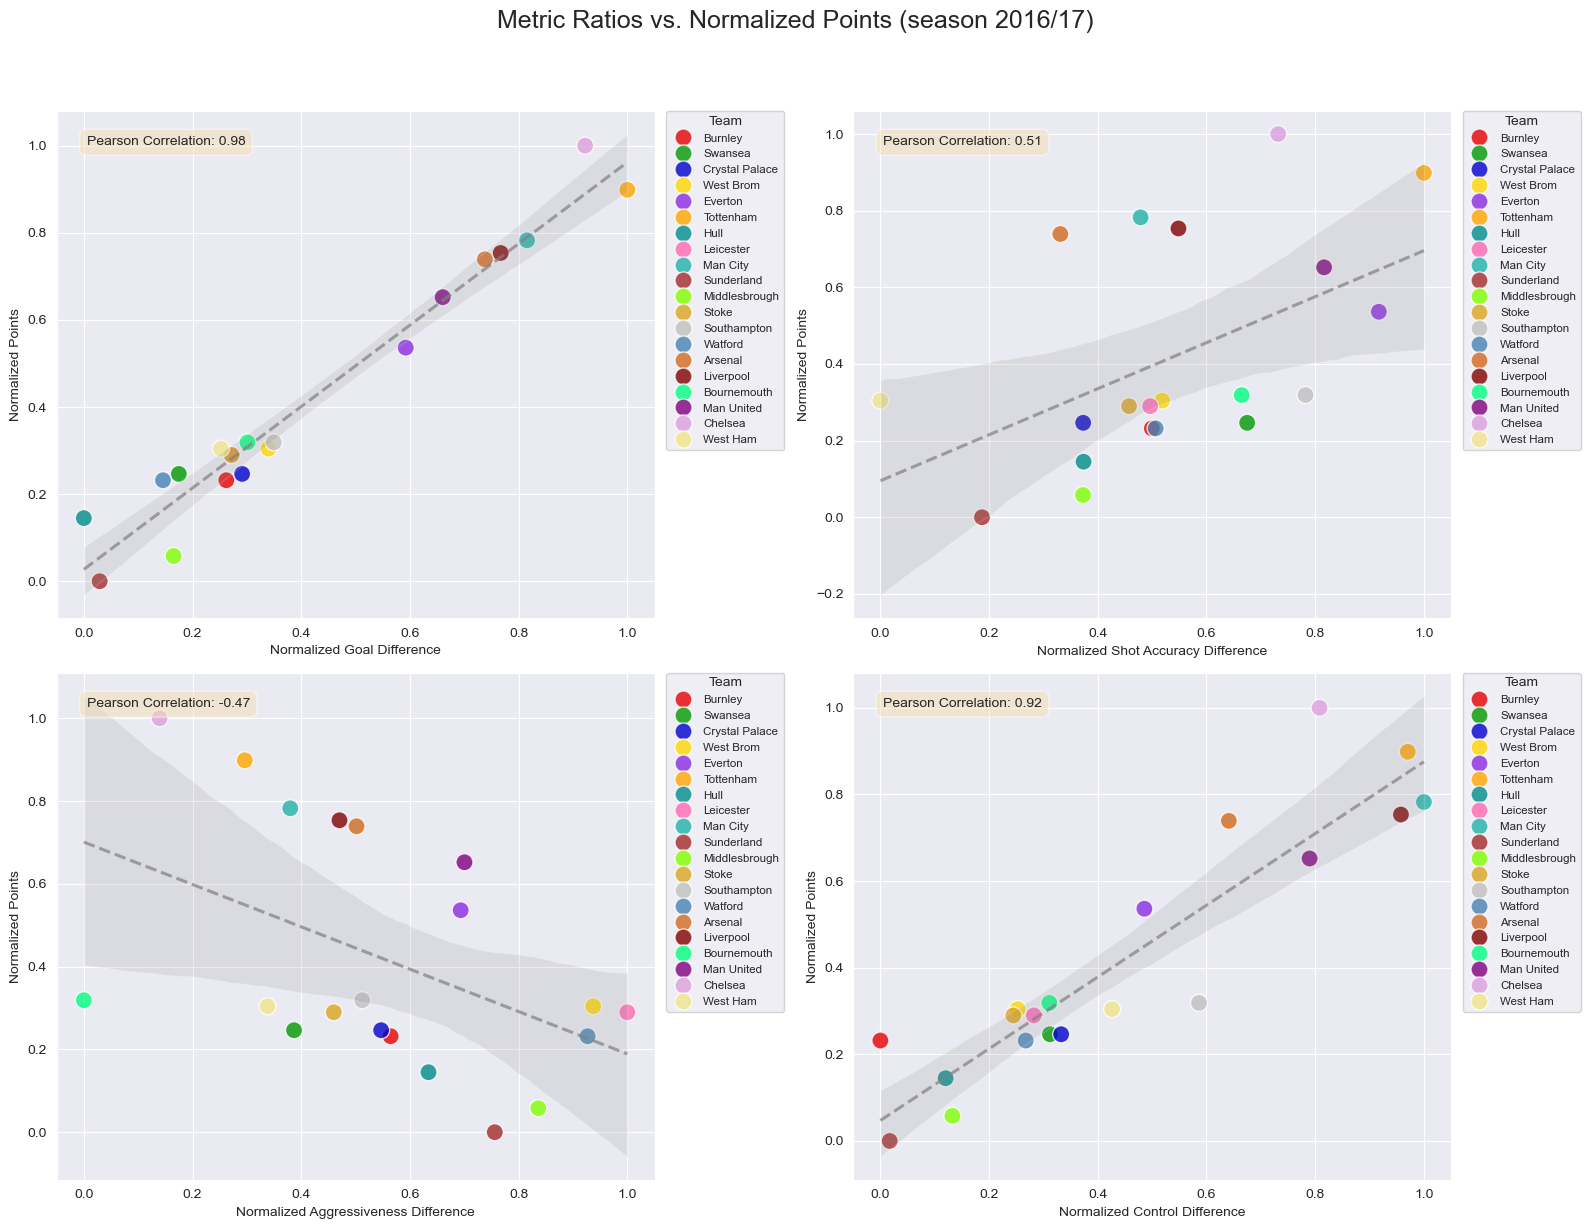


--- EPL Network Analysis Complete ---


In [981]:
# 1. Load the data
csv_file_path = '../data/epl_final.csv' # Adjust path as necessary
epl_df = load_data(csv_file_path)

if epl_df is None:
    print("Data loading failed. Exiting.")


# --- Scenario 1: Single Season Analysis (2016/17) with Normalized 'goals' ---
print("\n\n#####################################################################")
print("### Scenario 1: Single Season Analysis (2016/17) with Normalized 'goals' ###")
print("#####################################################################")
perform_epl_network_analysis(
    epl_df=epl_df,
    analysis_season='2016/17',
    normalize_weights=True,
)



#####################################################################
### Scenario 2: Multi-Season Analysis (2014-2017) ###
#####################################################################

--- Starting EPL Network Analysis for seasons from 2014/15 to 2016/17 ---
Network created for seasons from 2014/15 to 2016/17 with 24 nodes and 2136 edges.

--- Overall Network Properties ---
Number of nodes: 24
Number of edges: 2136
Network Density: 3.8696

Sample of Node Degrees (first 10 nodes - non-weighted):
  Node: Arsenal, In-Degree: 92, Out-Degree: 92, Total Degree: 184
  Node: Leicester, In-Degree: 92, Out-Degree: 92, Total Degree: 184
  Node: Man United, In-Degree: 92, Out-Degree: 92, Total Degree: 184
  Node: QPR, In-Degree: 76, Out-Degree: 76, Total Degree: 152
  Node: Stoke, In-Degree: 92, Out-Degree: 92, Total Degree: 184
  Node: West Brom, In-Degree: 92, Out-Degree: 92, Total Degree: 184
  Node: West Ham, In-Degree: 92, Out-Degree: 92, Total Degree: 184
  Node: Liverpool, In-De

/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_35539/3994569309.py:43: UserWarning: The palette list has more values (46) than needed (26), which may not be intended.
  sns.scatterplot(
/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_35539/3994569309.py:43: UserWarning: The palette list has more values (46) than needed (26), which may not be intended.
  sns.scatterplot(
/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_35539/3994569309.py:43: UserWarning: The palette list has more values (46) than needed (26), which may not be intended.
  sns.scatterplot(
/var/folders/f3/vgmbz_1j6c375y52l9k_9l980000gn/T/ipykernel_35539/3994569309.py:43: UserWarning: The palette list has more values (46) than needed (26), which may not be intended.
  sns.scatterplot(


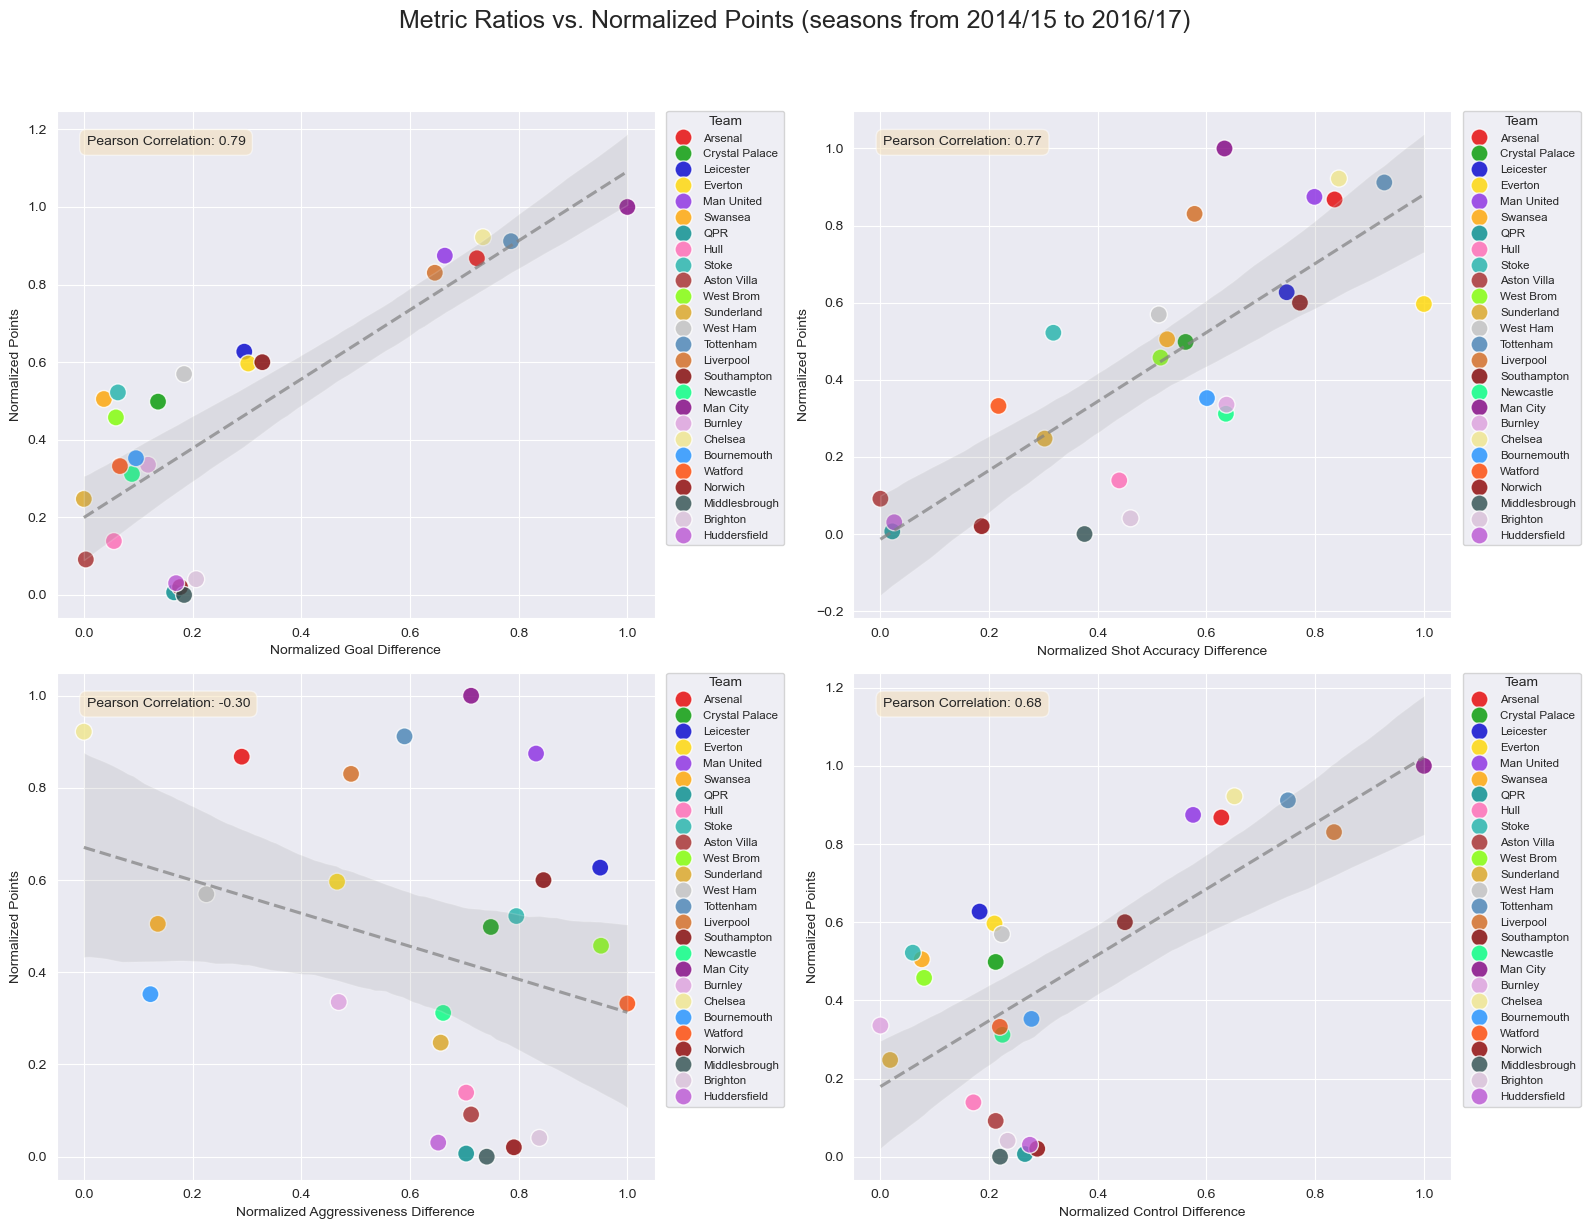


--- EPL Network Analysis Complete ---


In [982]:
# --- Scenario 2: Multi-Season Analysis (2014-2017) on 'aggressiveness', No Normalization, with Filtering ---
print("\n\n#####################################################################")
print("### Scenario 2: Multi-Season Analysis (2014-2017) ###")
print("#####################################################################")
perform_epl_network_analysis(
    epl_df=epl_df,
    network_start_year=2014,
    network_end_year=2017,
    normalize_weights=True, # No normalization for this scenario # Apply filtering
)

In [983]:
plt.show()

In [984]:
METRIC_FOR_ANALYSIS = 'goals'

graph_to_analyze = epl_network

if graph_to_analyze:
    print(f"\n--- Analyzing Network with Metric: '{METRIC_FOR_ANALYSIS}' ---")

    # --- Step 2: Basic Network Descriptors (Using a single metric view) ---
    # To calculate descriptors like density, average path length, clustering coefficient
    # on a MultiDiGraph, you generally need to project it onto a simpler graph
    # representing the chosen metric.

    # Create a simple DiGraph from the MultiDiGraph for the chosen metric
    G_single_metric = nx.DiGraph()
    G_single_metric.add_nodes_from(graph_to_analyze.nodes())

    for u, v, key, data in graph_to_analyze.edges(keys=True, data=True):
        if key == METRIC_FOR_ANALYSIS:
            # Aggregate weights if multiple edges of the same type exist (shouldn't if correctly built)
            if G_single_metric.has_edge(u, v):
                G_single_metric[u][v]['weight'] += data['weight']
            else:
                G_single_metric.add_edge(u, v, weight=data['weight'])

    if not G_single_metric.edges():
        print(f"No edges found for '{METRIC_FOR_ANALYSIS}' metric in the graph. Cannot perform detailed analysis.")
        # Proceed with only node-based analysis if no edges
    else:
        print("\n--- Basic Network Descriptors for Selected Metric Graph ---")
        print(f"Number of nodes: {G_single_metric.number_of_nodes()}")
        print(f"Number of edges (for '{METRIC_FOR_ANALYSIS}'): {G_single_metric.number_of_edges()}")

        # Density for directed graph
        density = nx.density(G_single_metric)
        print(f"Network Density ('{METRIC_FOR_ANALYSIS}'): {density:.4f}")

        # Average Degree (in-degree, out-degree, total degree)
        print("\nSample of Node Degrees (first 5-10 nodes):")
        for i, node in enumerate(G_single_metric.nodes()):
            in_degree = G_single_metric.in_degree(node)
            out_degree = G_single_metric.out_degree(node)
            print(f"  Node: {node}, In-Degree: {in_degree}, Out-Degree: {out_degree}, Total Degree: {in_degree + out_degree}")
            if i >= 9: break

        # Strength Centrality (Weighted Degree - using chosen metric)
        print(f"\nSample of Node Strengths (Weighted Degrees - '{METRIC_FOR_ANALYSIS}') (first 5-10 nodes):")
        for i, node in enumerate(G_single_metric.nodes()):
            # For directed graph, you might want in-strength and out-strength
            in_strength = sum(G_single_metric[n][node]['weight'] for n in G_single_metric.predecessors(node))
            out_strength = sum(G_single_metric[node][n]['weight'] for n in G_single_metric.neighbors(node))
            print(f"  Node: {node}, In-Strength: {in_strength:.2f}, Out-Strength: {out_strength:.2f}")
            if i >= 9: break
        
        # Note: Average Shortest Path Length and Clustering Coefficient are typically for undirected graphs
        # or require specific considerations for directed/weighted graphs.
        # For simplicity, we'll focus on centrality measures that naturally handle directed/weighted graphs.

        # --- Step 3: Centrality Measures ---
        print("\n--- Centrality Measures (based on '" + METRIC_FOR_ANALYSIS + "' metric) ---")

        # Degree Centrality (In-degree and Out-degree)
        in_degree_centrality = nx.in_degree_centrality(G_single_metric)
        out_degree_centrality = nx.out_degree_centrality(G_single_metric)
        print("\nTop 5 In-Degree Centrality:")
        for team, centrality in sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse=True)[:5]:
            print(f"  {team}: {centrality:.4f}")
        print("\nTop 5 Out-Degree Centrality:")
        for team, centrality in sorted(out_degree_centrality.items(), key=lambda item: item[1], reverse=True)[:5]:
            print(f"  {team}: {centrality:.4f}")

        # Strength Centrality (Weighted Degree - using chosen metric)
        # We already calculated this as in_strength and out_strength. Let's make them dictionaries.
        in_strength_centrality = {node: sum(G_single_metric[n][node].get('weight', 0) for n in G_single_metric.predecessors(node))
                                  for node in G_single_metric.nodes()}
        out_strength_centrality = {node: sum(G_single_metric[node][n].get('weight', 0) for n in G_single_metric.neighbors(node))
                                   for node in G_single_metric.nodes()}
        print("\nTop 5 In-Strength Centrality:")
        for team, centrality in sorted(in_strength_centrality.items(), key=lambda item: item[1], reverse=True)[:5]:
            print(f"  {team}: {centrality:.2f}")
        print("\nTop 5 Out-Strength Centrality:")
        for team, centrality in sorted(out_strength_centrality.items(), key=lambda item: item[1], reverse=True)[:5]:
            print(f"  {team}: {centrality:.2f}")


        # Betweenness Centrality (can be computationally intensive)
        print("\nCalculating Betweenness Centrality (this may take a moment)...")
        # For directed graphs, betweenness can be calculated for paths (using 'weight' for path length)
        # Note: If 'weight' represents 'strength' (e.g., goals), then 'distance' should be inverse of weight for shortest path algorithms
        # e.g., distance = 1/weight
        # Let's use 1/weight as the 'distance' for shortest path calculations for closeness and betweenness
        for u, v, d in G_single_metric.edges(data=True):
            d['distance'] = 1 / d['weight'] if d['weight'] > 0 else float('inf') # Avoid division by zero and handle zero weight

        betweenness_centrality = nx.betweenness_centrality(G_single_metric, weight='distance')
        print("Top 5 Betweenness Centrality:")
        for team, centrality in sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)[:5]:
            print(f"  {team}: {centrality:.4f}")

        # Closeness Centrality
        print("\nCalculating Closeness Centrality (this may take a moment)...")
        closeness_centrality = nx.closeness_centrality(G_single_metric, distance='distance')
        print("Top 5 Closeness Centrality:")
        for team, centrality in sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)[:5]:
            print(f"  {team}: {centrality:.4f}")

        # Eigenvector Centrality
        print("\nCalculating Eigenvector Centrality (this may take a moment)...")
        try:
            # For directed graphs, Eigenvector Centrality often uses the adjacency matrix directly,
            # or in_neighbors for incoming influence, out_neighbors for outgoing influence.
            # Default behavior usually considers both. If you want specific 'influence', specify `max_iter` or `tol`.
            eigenvector_centrality = nx.eigenvector_centrality(G_single_metric, weight='weight', max_iter=1000)
            print("Top 5 Eigenvector Centrality:")
            for team, centrality in sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)[:5]:
                print(f"  {team}: {centrality:.4f}")
        except nx.PowerIterationFailedConvergence:
            print("Eigenvector centrality did not converge. This can happen with certain graph structures or with non-positive weights.")
            eigenvector_centrality = {node: 0 for node in G_single_metric.nodes()} # Initialize to 0 if not converged


        # --- Step 4: Integrate with External Data (League Standings) ---
        team_points = {team: 0 for team in graph_to_analyze.nodes()}
        season_matches = epl_df[epl_df['Season'] == selected_season]

        for index, row in season_matches.iterrows():
            home_team = row['HomeTeam']
            away_team = row['AwayTeam']
            full_time_result = row['FullTimeResult'] # 'H' for Home win, 'A' for Away win, 'D' for Draw

            if full_time_result == 'H':
                team_points[home_team] = team_points.get(home_team, 0) + 3
            elif full_time_result == 'A':
                team_points[away_team] = team_points.get(away_team, 0) + 3
            else: # Draw
                team_points[home_team] = team_points.get(home_team, 0) + 1
                team_points[away_team] = team_points.get(away_team, 0) + 1

        print("\n--- Team Points for the Season ---")
        sorted_teams_by_points = sorted(team_points.items(), key=lambda item: item[1], reverse=True)
        for team, points in sorted_teams_by_points[:10]:
            print(f"  {team}: {points} points")

        # --- Step 5: Correlation Analysis (e.g., Centrality vs. Points) ---
        print("\n--- Correlation Analysis: Centrality vs. League Points ---")

        teams = list(G_single_metric.nodes()) # Use nodes from the single metric graph for consistency
        points = [team_points.get(team, 0) for team in teams]

        centrality_data = {
            'In-Degree': [in_degree_centrality.get(team, 0) for team in teams],
            'Out-Degree': [out_degree_centrality.get(team, 0) for team in teams],
            'In-Strength': [in_strength_centrality.get(team, 0) for team in teams],
            'Out-Strength': [out_strength_centrality.get(team, 0) for team in teams],
            'Betweenness': [betweenness_centrality.get(team, 0) for team in teams],
            'Closeness': [closeness_centrality.get(team, 0) for team in teams],
            'Eigenvector': [eigenvector_centrality.get(team, 0) for team in teams]
        }

        results_df = pd.DataFrame({
            'Team': teams,
            'Points': points,
            **centrality_data
        })

        print("\nCentrality and Points Data Sample:")
        print(results_df.head())

        print(f"\nPearson Correlation between Centrality Measures (based on '{METRIC_FOR_ANALYSIS}') and League Points:")
        for centrality_type, values in centrality_data.items():
            # Check if there's enough variance for correlation
            if len(set(values)) > 1: # If all values are the same, correlation is undefined
                correlation = results_df['Points'].corr(results_df[centrality_type])
                print(f"  {centrality_type} Centrality vs. Points: {correlation:.4f}")
            else:
                print(f"  {centrality_type} Centrality vs. Points: Cannot calculate (no variance in centrality values)")

        # --- Step 6: Visualization of Centrality vs. Points ---
        print("\n--- Visualizing Centrality vs. Points ---")

        # Filter out centrality measures that are all zeros or constant if they cause issues
        plottable_centralities = {k: v for k, v in centrality_data.items() if len(set(v)) > 1}

        if plottable_centralities:
            fig, axes = plt.subplots(len(plottable_centralities), 1, figsize=(10, 5 * len(plottable_centralities)))
            # If there's only one subplot, axes might not be an array, handle it
            if len(plottable_centralities) == 1:
                axes = [axes]
            
            fig.suptitle(f'Centrality Measures ({METRIC_FOR_ANALYSIS} Metric) vs. League Points ({selected_season})', fontsize=16)

            for i, (centrality_type, values) in enumerate(plottable_centralities.items()):
                ax = axes[i]
                sns.regplot(x=results_df[centrality_type], y=results_df['Points'], ax=ax)
                correlation_val = results_df['Points'].corr(results_df[centrality_type])
                ax.set_title(f'{centrality_type} Centrality vs. Points (Corr: {correlation_val:.2f})')
                ax.set_xlabel(f'{centrality_type} Centrality')
                ax.set_ylabel('League Points')

            plt.tight_layout(rect=[0, 0.03, 1, 0.96])
            plt.show()
        else:
            print("No centrality measures with variance to plot against points.")

        # --- Step 7: Network Visualization (Using the selected metric) ---
        # Visualize the network using the chosen metric's edges
        visualize_network(graph_to_analyze, selected_season, metric_to_display=METRIC_FOR_ANALYSIS)


else:
    print("No graph available for analysis. Please ensure network creation was successful.")

NameError: name 'epl_network' is not defined

In [ ]:
# Visualize the network for a specific metric (e.g., "goals")
visualize_network(epl_network, selected_season, metric_to_display="goals", file_name=f'network_{selected_season.replace("/", "-")}_goals.png')

In [ ]:
# Visualize the network for another metric (e.g., "shot_accuracy"
visualize_network(epl_network, selected_season, metric_to_display="shot_accuracy", file_name=f'network_{selected_season.replace("/", "-")}_shot_accuracy.png')

In [ ]:
# Example of how to access edge data:
print("\nExample edge data (e.g., Arsenal -> a Tottenham team):")
team1_name_example = 'Arsenal'
team2_partial_name_example = 'Tottenham' # We'll search for a team containing this string

actual_team1_name = None
actual_team2_name = None
available_nodes = list(epl_network.nodes())

for node_name in available_nodes:
    if team1_name_example in node_name: # Simple check, might need refinement for exact match
        actual_team1_name = node_name
    if team2_partial_name_example in node_name:
        actual_team2_name = node_name

if actual_team1_name and actual_team2_name and epl_network.has_edge(actual_team1_name, actual_team2_name):
    print(f"Edges from {actual_team1_name} to {actual_team2_name}:")
    # Correct iteration for MultiDiGraph's get_edge_data().items()
    for metric_key, key_dict_val in epl_network.get_edge_data(actual_team1_name, actual_team2_name).items():
         print(f"  Metric: {metric_key}, Weight: {key_dict_val.get('weight', 'N/A'):.2f}")
elif actual_team1_name and actual_team2_name:
    print(f"  No direct edges found from {actual_team1_name} to {actual_team2_name} in the graph for season {selected_season}.")
else:
    print(f"  Could not find one or both teams ('{team1_name_example}', '{team2_partial_name_example}') as nodes in the network for this season.")

Okay, now that your network is created and functioning, we can dive into analyzing it! Network analysis can reveal fascinating structural properties and potential groupings (communities) within the Premier League based on the metrics you've defined.

We'll explore:
1.  **Basic Structural Properties:** A quick look at the overall network.
2.  **Node-Level Centrality Analysis:** Identifying key teams based on different metrics.
3.  **Community Detection:** Discovering groups of teams that are more densely interconnected by certain metrics.

Let's assume your main `MultiDiGraph` is stored in a variable called `epl_network` (or `full_dataset_network` if you analyzed the whole dataset). I'll use `G_multi` as a generic placeholder for the graph object in the functions.

---

## 1. Preparing for Metric-Specific Analysis

Since your main graph is a `MultiDiGraph` (multiple types of edges between nodes), many standard NetworkX analysis functions work best on simpler `DiGraph` (directed) or `Graph` (undirected) instances, typically focusing on one relationship type at a time.

Let's create a helper function to extract a subgraph for a specific metric.


In [ ]:

import networkx as nx
import pandas as pd # For Series in centrality display
import matplotlib.pyplot as plt # For any potential inline plots if needed

def extract_metric_graph(G_multi, metric_key, make_undirected=False, default_weight_for_missing=0):
    """
    Extracts a DiGraph or Graph for a specific metric from a MultiDiGraph.

    Args:
        G_multi (nx.MultiDiGraph): The input multi-directed graph.
        metric_key (str): The key of the metric to extract (e.g., "goals", "control").
        make_undirected (bool): If True, returns an undirected Graph.
                                If False, returns a DiGraph.
        default_weight_for_missing (float): Weight to assign if an edge for the metric_key
                                            is technically present but weight attribute is missing.

    Returns:
        nx.DiGraph or nx.Graph: A graph with only the specified metric's edges.
                                Nodes are preserved.
    """
    if make_undirected:
        H = nx.Graph()
    else:
        H = nx.DiGraph()
    
    H.add_nodes_from(G_multi.nodes()) # Ensure all teams are in the new graph

    for u, v, data in G_multi.edges(data=True):
        if data.get('key') == metric_key:
            weight = data.get('weight', default_weight_for_missing)
            if H.has_edge(u, v):
                # If multiple edges of the same metric_key exist (should not with current create_epl_network)
                # or if converting to undirected and edge u-v already considered from v-u
                if make_undirected:
                     # Simple sum for undirected if edges appear in both directions
                    H[u][v]['weight'] = H[u][v].get('weight', 0) + weight
                else: # Directed, multiple edges of same type not expected by current creation logic
                    H[u][v]['weight'] = max(H[u][v].get('weight', 0), weight) # Or sum, depends on desired logic
            else:
                H.add_edge(u, v, weight=weight)
    return H

# Example of how to use it (assuming 'epl_network' is your created graph)
# G_goals = extract_metric_graph(epl_network, "goals")
# G_control = extract_metric_graph(epl_network, "control")



---

## 2. Structural Network Properties

### Basic Network Density
Network density tells us how many connections exist compared to the maximum possible connections. For `MultiDiGraph`, it's a bit nuanced. We can calculate it for specific metric subgraphs.


In [ ]:

# Assuming epl_network is your MultiDiGraph and you've run the previous cell
# Let's analyze the density of the "goals" interaction graph
G_goals = extract_metric_graph(epl_network, "goals") # Directed graph for goals

if G_goals.number_of_nodes() > 0:
    density_goals = nx.density(G_goals)
    print(f"Density of the 'goals' interaction graph: {density_goals:.4f}")
else:
    print("Graph for 'goals' is empty or not created.")

# What it might mean:
# A higher density in a directed "goals" graph (where an edge A->B means A scored on B)
# would mean that teams tend to score against a larger proportion of other teams.
# In a league where everyone plays everyone, the number of actual directed edges will be n*(n-1).
# The nx.density for DiGraph is m / (n*(n-1)). If all teams scored at least one goal against all others, density would be 1.
# Lower density means scoring is more sparse or selective.



### Interpretation of Density:
The density calculated by `nx.density` for a `DiGraph` is $m / (n(n-1))$, where $m$ is the number of edges and $n$ is the number of nodes. If every team scored against every other team at least once (creating an edge), the density would be 1.0. A lower value indicates that scoring relationships are more sparse.

---

## 3. Node-Level Centrality Analysis (Identifying Key Teams)

Centrality measures help identify the most "important" or "influential" nodes (teams) in the network according to different criteria. We'll look at degree centrality and PageRank, focusing on specific metric subgraphs.

### 3.1. Degree Centrality (In-Degree and Out-Degree)

* **Out-Degree:** For a team, this can represent how many other teams it "acts upon" for a given metric (e.g., scores against, exerts control over).
* **In-Degree:** Represents how many other teams "act upon" it (e.g., score against it, exert control over it).
* **Weighted Degree:** Considers the weights of the edges, giving a measure of the total strength of interaction.

Let's analyze this for the "goals" and "control" metrics.


In [ ]:

def print_top_n_centrality(centrality_dict, metric_name, n=5):
    """Helper function to print top N teams from a centrality dictionary."""
    if not centrality_dict:
        print(f"No {metric_name} centrality data to display.")
        return
    
    sorted_teams = sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)
    print(f"\n--- Top {n} teams by {metric_name} ---")
    for i, (team, score) in enumerate(sorted_teams[:n]):
        print(f"{i+1}. {team}: {score:.2f}")

# --- Analysis for "goals" metric ---
# G_goals was created earlier: G_goals = extract_metric_graph(epl_network, "goals")
if 'G_goals' in locals() and G_goals.number_of_nodes() > 0:
    # Out-degree strength for "goals" (Total goals scored by each team)
    goals_scored_strength = dict(G_goals.out_degree(weight='weight'))
    print_top_n_centrality(goals_scored_strength, "'goals' Scored (Weighted Out-Degree)")

    # In-degree strength for "goals" (Total goals conceded by each team)
    goals_conceded_strength = dict(G_goals.in_degree(weight='weight'))
    print_top_n_centrality(goals_conceded_strength, "'goals' Conceded (Weighted In-Degree)")
else:
    print("Skipping 'goals' centrality analysis as G_goals is not properly defined or is empty.")

# --- Analysis for "control" metric ---
G_control = extract_metric_graph(epl_network, "control")
if G_control.number_of_nodes() > 0:
    # Out-degree strength for "control" (Total control exerted by each team)
    control_exerted_strength = dict(G_control.out_degree(weight='weight'))
    print_top_n_centrality(control_exerted_strength, "'control' Exerted (Weighted Out-Degree)")

    # In-degree strength for "control" (Total control received/faced by each team)
    control_faced_strength = dict(G_control.in_degree(weight='weight'))
    print_top_n_centrality(control_faced_strength, "'control' Faced (Weighted In-Degree)")
else:
    print("Skipping 'control' centrality analysis as G_control is not properly defined or is empty.")

# Similarly for "aggressiveness" and "shot_accuracy"
# For "shot_accuracy", you might be interested in the average accuracy (out-degree weight / out-degree count)
# or just the weighted out-degree if you consider higher total weighted accuracy against opponents as better.



### Interpretation of Degree Centrality:

* **Goals Scored (Weighted Out-Degree for "goals"):** Teams ranked high here are prolific scorers against their opponents over the season/dataset. These are likely the top attacking teams.
* **Goals Conceded (Weighted In-Degree for "goals"):** Teams ranked high here have conceded the most goals. These indicate teams with defensive vulnerabilities.
* **Control Exerted (Weighted Out-Degree for "control"):** Teams high on this list dominate their matches more in terms of shots and corners against opponents.
* **Control Faced (Weighted In-Degree for "control"):** Teams high here are often on the receiving end of opponent's territorial dominance.

### 3.2. PageRank Centrality

PageRank (and Eigenvector Centrality) measures the influence of a node by considering the importance of its neighbors. A team is important if it scores against (or controls, etc.) other important/strong teams.


In [ ]:

# --- PageRank for "goals" metric (who scores against strong opponents or teams that concede less) ---
# Note: PageRank on a "goals scored" graph implies that receiving a link means "being scored upon".
# So, a team with high PageRank is one that is frequently scored upon by teams that themselves are scored upon a lot...
# This might be counterintuitive for goals.
# Let's try PageRank on a graph where edges A->B mean A DOMINATES B in terms of goals (e.g. A scored more than average on B)
# Or, more simply, PageRank on the raw "goals scored" graph:
# A high PageRank score for team T means that T is scored against by many teams U,
# especially if those teams U themselves are scored against by many other (potentially "important") teams.
# This interpretation can be tricky.

# Let's consider PageRank on the "control" graph where A->B means A exerts control over B.
# A high PageRank score for team T would mean that T exerts control over teams U,
# where these teams U are themselves influential (i.e., they exert control over many or important other teams).
# This indicates a team that can dominate already dominant teams.

if 'G_control' in locals() and G_control.number_of_nodes() > 0:
    try:
        pagerank_control = nx.pagerank(G_control, weight='weight')
        print_top_n_centrality(pagerank_control, "PageRank on 'control' graph")
    except nx.NetworkXError as e:
        print(f"Could not calculate PageRank for 'control' graph (possibly due to graph structure): {e}")
else:
    print("Skipping PageRank for 'control' as G_control is not properly defined or is empty.")
    
# --- PageRank for "goals" metric ---
# If A->B edge means A scored on B, then teams that get "linked to" (i.e., are scored upon) by 
# teams that score a lot (or score on many others) will get high PageRank.
# This means high PageRank teams are those that are vulnerable to strong attacking teams.
if 'G_goals' in locals() and G_goals.number_of_nodes() > 0:
    try:
        # Invert weights for goals conceded? Or use as is?
        # If weight is goals scored, high pagerank = scored on by influential scorers
        pagerank_goals_conceded_profile = nx.pagerank(G_goals, weight='weight')
        print_top_n_centrality(pagerank_goals_conceded_profile, "PageRank on 'goals' graph (profile of being scored on)")
    except nx.NetworkXError as e:
        print(f"Could not calculate PageRank for 'goals' graph: {e}")
else:
    print("Skipping PageRank for 'goals' as G_goals is not properly defined or is empty.")




### Interpretation of PageRank:

* **PageRank on "control" graph (A exerts control on B):** Teams with high PageRank are those that exert significant control, especially over other teams that are themselves central in the "control" network. These are truly influential teams in terms of game dominance.
* **PageRank on "goals" graph (A scores on B):** This is a bit more complex to interpret directly for "team strength." A team `T` gets a high PageRank if it is scored upon (`U -> T`) by teams `U` that are "important" (meaning `U` scores on many or important teams). So, high PageRank here might indicate teams that are defensively vulnerable to prolific/influential attacking sides.

---

## 4. Community Detection

Community detection algorithms aim to find groups of nodes (teams) that are more densely connected to each other within their group than to nodes outside their group. For this, we usually need an undirected graph.

Let's try to find communities based on the **total control exchanged** between teams.
1.  Extract the "control" graph (A -> B with weight = A's control vs B).
2.  Create an undirected graph where the edge weight between A and B is the sum of (A's control vs B) + (B's control vs A).
3.  Apply the Louvain community detection algorithm.


In [ ]:

# Community detection based on "total control exchanged"
if 'G_control' in locals() and G_control.number_of_nodes() > 0:
    # Create an undirected graph representing total control interaction
    G_control_undirected = nx.Graph()
    G_control_undirected.add_nodes_from(G_control.nodes())

    for u, v, data in G_control.edges(data=True): # Iterate through directed control edges
        weight_uv = data.get('weight', 0)
        # For edge u-v in undirected graph, add weight from u->v
        current_weight = G_control_undirected.get_edge_data(u,v, default={'weight':0})['weight']
        G_control_undirected.add_edge(u, v, weight=current_weight + weight_uv)
        
    # Check if the graph has edges before running community detection
    if G_control_undirected.number_of_edges() > 0:
        print("\n--- Detecting Communities based on 'Total Control Exchanged' ---")
        try:
            # Louvain algorithm requires positive weights if the implementation details matter.
            # Ensure all weights are non-negative; our control metric should be.
            communities_louvain_control = nx.community.louvain_communities(G_control_undirected, weight='weight', seed=42)
            
            print(f"Found {len(communities_louvain_control)} communities for 'Total Control Exchanged':")
            for i, community in enumerate(communities_louvain_control):
                print(f"Community {i+1}: {sorted(list(community))}")
        except Exception as e: # Catch any error during community detection
             print(f"Could not perform Louvain community detection: {e}")
             print("This can happen if the graph has no edges or other structural issues for the algorithm.")
    else:
        print("Undirected 'control' graph has no edges, skipping community detection.")
else:
    print("Skipping community detection for 'control' as G_control is not defined or is empty.")




### Interpretation of Communities (e.g., for "Total Control Exchanged"):

* **Clusters of High Interaction:** Communities might represent groups of teams that have very active "control battles" amongst themselves – meaning the sum of control exerted by A on B and B on A is high within the group.
* **Playing Style Groups:** Potentially, these communities could group teams with similar overall intensity or style regarding territorial dominance (either exerting it or facing it strongly within the community).
* **League Tiers (Hypothetical):** If top teams consistently have high control exchanges only among themselves, and similarly for mid-table or bottom teams, communities might reflect these competitive tiers. This is speculative and depends heavily on the data.

---

### Further Analysis Steps:

* **Thresholding:** For some analyses (especially community detection or visualization), you might want to create graphs where edges only exist if their weight exceeds a certain threshold (e.g., only show "strong" control relationships).
* **Evolution over Seasons:** If you run this analysis for multiple individual seasons, you can track how team centralities and community structures change over time.
* **Combining Metrics:** More advanced analysis could involve creating a weighted graph where edge weights are a composite score from multiple metrics, though this requires careful normalization and weighting of each metric.
* **Statistical Significance:** For community structures or centrality scores, one might consider statistical tests to see if the observed patterns are significant or likely due to chance (more advanced).

This provides a starting point for your structural and community analysis. Remember that the interpretation of these network metrics is key and should always be tied back to the specific meaning of your edge definitions and the context of football!